In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

sys.path.append('../')
import dataio, utils, icnn_pytorch_adaptive as icnn_pytorch

In [2]:

ckpt_path = '../train_new_case_follow_zero_relative/t_10/checkpoints_dir/model_final.pth'
model_2 = '../train_new_case_follow_zero_relative/t_9/checkpoints_dir/model_final.pth'


activation = 'relu'

model = icnn_pytorch.SingleBVPNet(in_features=5, out_features=1, type=activation, mode='mlp', hidden_features=128, num_hidden_layers=2, dropout=0)

model2 = icnn_pytorch.SingleBVPNet(in_features=5, out_features=1, type=activation, mode='mlp', hidden_features=128, num_hidden_layers=2, dropout=0)

checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
c2 = torch.load(model_2, map_location=torch.device("cpu"))

try:
    model_weights = checkpoint['model']
except:
    model_weights = checkpoint

try:
    mw = c2['model']
except:
    mw = c2

model.load_state_dict(model_weights)
model2.load_state_dict(mw)
model.eval()
model2.eval()

SingleBVPNet(
  (net): FCBlock(
    (nl): ReLU(inplace=True)
    (net_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=4, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_zu_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_z_zu): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_yu_u)

SingleBVPNet(
  (net): FCBlock(
    (nl): ReLU(inplace=True)
    (net_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=4, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_zu_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_z_zu): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_yu_u)

In [4]:
## define the dynamics

def dynamics_zero_relative(x, u, d, DT=0.1):
    from itertools import product
    def get_p2_a(x, d_max):
        v = x[..., 3]  # p2's velocity

        a_l = -d_max * np.ones_like(v)
        a_r = d_max * np.ones_like(v)

        ## try catch block for when input is just one state vs multiple states.
        try:
            a_l[np.where(v == 0)] = -d_max
            a_r[np.where(v == 0)] = d_max
            a_l[np.where(v < 0)] = -d_max
            a_r[np.where(v < 0)] = 0.5 * d_max

            a_l[np.where(v > 0)] = -0.5 * d_max
            a_r[np.where(v > 0)] = d_max
        except:
            a_l = -d_max if v < 0 else -0.5 * d_max
            a_r = 0.5 * d_max if v < 0 else d_max

        return a_l, a_r

    U = np.array([-np.ones_like(x[..., 2]).reshape(-1, 1), np.zeros_like(x[..., 2]).reshape(-1, 1), np.ones_like(x[..., 2]).reshape(-1, 1)]).T.squeeze()
    d1, d2 = get_p2_a(x, d)
    D = np.vstack((d1, np.zeros_like(d1), d2)).T
    dt = DT
    da = [np.array([a - b for a, b in product(U, D)])]

    da = np.array(da)
    da_x = da * 0.5 * dt ** 2

    x_new = np.array([x[..., 1] + dt * (x[..., 2] - x[..., 3]) + a for a in da_x]).T.reshape(-1, 1)

    v1_new = x[..., 2].reshape(-1, 1) + U * dt
    v2_new = x[..., 3].reshape(-1, 1) + D * dt


    X_new = np.hstack((x_new.reshape(-1, 1), v1_new.repeat(3).reshape(-1, 1),
                       v2_new.repeat(3).reshape(-1, 1)))  # returns new states, n x 8

    return X_new

In [5]:
# Compute value at current time-step

X = torch.zeros((100, 4))
p_T = torch.linspace(0, 1, 100).reshape(-1, 1)

X = torch.cat((X, p_T), dim=1)


# also plot value at next time step
X[:, 0] = 1  # time
X[:, 1] = 0. # pos
X[:, 2] = 0. # v1
X[:, 3] = 0. # v2
X_in = {'coords': X}
v2 = model(X_in)['model_out'].detach().cpu().numpy()

In [6]:
## compute min max value at next time-step
delta_t = 0.1
V1 = []
t = 0.9  #
actions = []
values = []
# X = torch.tensor([[t, delta_x, delta_v]], dtype=torch.float32)
for p in torch.linspace(0, 1, 100):
    X = np.zeros((1, 4), dtype=np.float32)
    X[:, 1] = 0.
    X[:, 2] = 0.
    X[:, 3] = 0.
    p_T = torch.linspace(0, 1, 9).reshape(-1, 1)
    p_T[:, ] = p

    X_new = torch.from_numpy(dynamics_zero_relative(X, 1, 1, DT=delta_t))
    X_new = torch.cat((torch.ones(X_new.shape[0], 1), X_new), dim=1)
    X = torch.cat((X_new, p_T), dim=1)
    X[:, 0] = t
    X_in = {'coords': X}
    value = model2(X_in)['model_out'].detach().cpu().numpy()
    # value = utils.final_value_minmax((X[:, 1]), X[:, -1]).numpy()  # uncomment this to calculate value at T-dt
    values.append(value)
    minmaxV = value.reshape(3, 3)

    a_idx = np.argmin(np.max(minmaxV, axis=1))
    d_idx = np.argmax(np.min(minmaxV, axis=0))


    V1.append(np.min(np.max(minmaxV, 1)))
    a_choices = [-1, 0, 1]
    actions.append(a_choices[a_idx])

In [7]:
from itertools import product

In [8]:
p = p_T.numpy()
points = zip(V1, p)
from utils import cav_vex

In [9]:
ps = np.linspace(0, 1, 100)
vex = []
for p in ps:
    vex.append(cav_vex(V1, p, type='vex', num_ps=100))

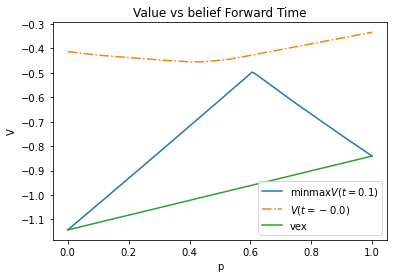

In [10]:
plt.plot(np.linspace(0, 1, 100), V1, label=f'$\min \max V(t={1 - t:.1f})$')
plt.plot(np.linspace(0, 1, 100), v2, '-.', label=f'$V(t={1-t-0.1:.1f})$')
plt.plot(np.linspace(0, 1, 100), vex, label='vex')
plt.title('Value vs belief Forward Time')
plt.xlabel('p')
plt.ylabel('V')
plt.legend()
# plt.ylim([-1, 1])
plt.rcParams['figure.figsize'] = (8, 6)